<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/DAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DAM (Depth Anything Model)
Paper: https://arxiv.org/pdf/2401.10891
##Zero-shot prediction of DAM on surgical scene

raw input (706, 884)
in pixel_values: torch.Size([1, 3, 518, 644])
in self.embeddings: Dinov2Embeddings(
  (patch_embeddings): Dinov2PatchEmbeddings(
    (projection): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
  )
  (dropout): Dropout(p=0.0, inplace=False)
)
in self.embeddings: Dinov2Embeddings(
  (patch_embeddings): Dinov2PatchEmbeddings(
    (projection): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
  )
  (dropout): Dropout(p=0.0, inplace=False)
)
self.num_channels: 3
raw input (706, 884) inputs torch.Size([1, 3, 518, 644]) predicted_depth torch.Size([1, 518, 644])
Original model train on the scale of 0 to 30
prediction: min scale = 4.5153527 max scale= 18.96203


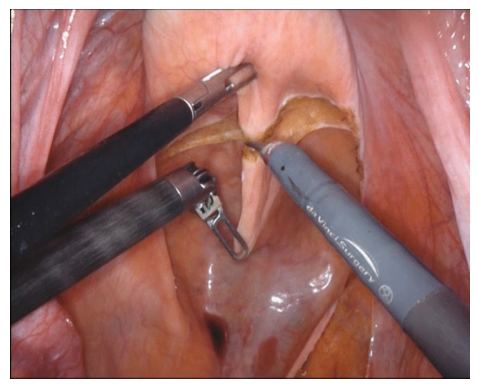

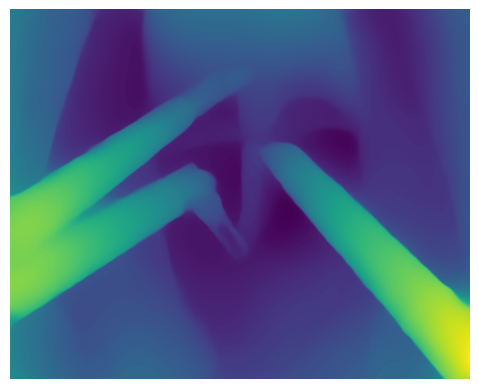

In [ ]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DepthAnythingForDepthEstimation
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt

url = "https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs13304-020-00913-4/MediaObjects/13304_2020_913_Fig2_HTML.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
model = DepthAnythingForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

print('raw input', image.size[::-1])

# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

print('raw input', image.size[::-1],'inputs',inputs['pixel_values'].shape, 'predicted_depth', predicted_depth.shape)
prediction = predicted_depth.clone()

# interpolate to original size
# prediction = torch.nn.functional.interpolate(
#     predicted_depth.unsqueeze(1),
#     size=image.size[::-1],
#     mode="bicubic",
#     align_corners=False,
# )

# visualize the prediction
output = prediction.squeeze().cpu().numpy()

print('Original model train on the scale of 0 to 30')
print('prediction: min scale =', output.min(), 'max scale=', output.max())

#Rescale the reconstruction according to your application
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = 1/np.array(image_processor.image_std)),
                                transforms.Normalize(mean = np.array(image_processor.image_mean)*-1,
                                                     std = [ 1., 1., 1. ]),
                               ])

inv_tensor = invTrans(inputs['pixel_values'])
plt.figure(121),plt.axis('OFF'),plt.imshow(inv_tensor.squeeze().permute(1,2,0))
plt.figure(122),plt.axis('OFF'),plt.imshow(depth);

In [ ]:
model.backbone.config.num_channels=6

Dinov2Config {
  "_attn_implementation_autoset": true,
  "apply_layernorm": true,
  "architectures": [
    "Dinov2Model"
  ],
  "attention_probs_dropout_prob": 0.0,
  "drop_path_rate": 0.0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "image_size": 518,
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-06,
  "layerscale_value": 1.0,
  "mlp_ratio": 4,
  "model_type": "dinov2",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "out_features": [
    "stage9",
    "stage10",
    "stage11",
    "stage12"
  ],
  "out_indices": [
    9,
    10,
    11,
    12
  ],
  "patch_size": 14,
  "qkv_bias": true,
  "reshape_hidden_states": false,
  "stage_names": [
    "stem",
    "stage1",
    "stage2",
    "stage3",
    "stage4",
    "stage5",
    "stage6",
    "stage7",
    "stage8",
    "stage9",
    "stage10",
    "stage11",
    "stage12"
  ],
  "torch_dtype": "float32",
  "transformers_version": "4.47.1",
  "use_swiglu_ffn": false
}

In [ ]:
model
#  for t_layer_i, blk in enumerate(dinov2.blocks):
#             # If we only want few lora layer instead of all
#             if t_layer_i not in self.lora_layer:
#                 continue
#             w_qkv_linear = blk.attn.qkv
#             self.dim = w_qkv_linear.in_features

DepthAnythingForDepthEstimation(
  (backbone): Dinov2Backbone(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2SdpaAttention(
            (attention): Dinov2SdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplac

In [ ]:
model.neck

DepthAnythingNeck(
  (reassemble_stage): DepthAnythingReassembleStage(
    (layers): ModuleList(
      (0): DepthAnythingReassembleLayer(
        (projection): Conv2d(384, 48, kernel_size=(1, 1), stride=(1, 1))
        (resize): ConvTranspose2d(48, 48, kernel_size=(4, 4), stride=(4, 4))
      )
      (1): DepthAnythingReassembleLayer(
        (projection): Conv2d(384, 96, kernel_size=(1, 1), stride=(1, 1))
        (resize): ConvTranspose2d(96, 96, kernel_size=(2, 2), stride=(2, 2))
      )
      (2): DepthAnythingReassembleLayer(
        (projection): Conv2d(384, 192, kernel_size=(1, 1), stride=(1, 1))
        (resize): Identity()
      )
      (3): DepthAnythingReassembleLayer(
        (projection): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
        (resize): Conv2d(384, 384, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
    )
  )
  (convs): ModuleList(
    (0): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): Conv2d(96, 64, 

In [ ]:
model.head

DepthAnythingDepthEstimationHead(
  (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation1): ReLU()
  (conv3): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
  (activation2): ReLU()
)

In [ ]:
# for model.backbone.encoder.layer
for t_layer_i, blk in enumerate(model.backbone.encoder.layer):
    print(t_layer_i)
    w_q = blk.attention.attention.query
    print(w_q)

0
Linear(in_features=384, out_features=384, bias=True)
1
Linear(in_features=384, out_features=384, bias=True)
2
Linear(in_features=384, out_features=384, bias=True)
3
Linear(in_features=384, out_features=384, bias=True)
4
Linear(in_features=384, out_features=384, bias=True)
5
Linear(in_features=384, out_features=384, bias=True)
6
Linear(in_features=384, out_features=384, bias=True)
7
Linear(in_features=384, out_features=384, bias=True)
8
Linear(in_features=384, out_features=384, bias=True)
9
Linear(in_features=384, out_features=384, bias=True)
10
Linear(in_features=384, out_features=384, bias=True)
11
Linear(in_features=384, out_features=384, bias=True)


In [ ]:
model.backbone

Dinov2Backbone(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-11): 12 x Dinov2Layer(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2SdpaAttention(
          (attention): Dinov2SdpaSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
        (drop

In [ ]:
print(model.backbone.embeddings.patch_embeddings.projection.weight.shape)
model.backbone.embeddings.patch_embeddings.projection.bias.shape

torch.Size([384, 3, 14, 14])


torch.Size([384])

In [ ]:
xx = nn.Conv2d(in_channels=6, out_channels=384, kernel_size=(14, 14), stride=(14, 14))
print(xx.weight.shape, xx.weight[:,:3,:,:].shape)
with torch.no_grad():
    xx.weight[:,:3,:,:] = model.backbone.embeddings.patch_embeddings.projection.weight
    xx.weight[:,3:6,:,:] = model.backbone.embeddings.patch_embeddings.projection.weight

torch.Size([384, 6, 14, 14]) torch.Size([384, 3, 14, 14])


In [ ]:
xx = nn.Conv2d(in_channels=6, out_channels=384, kernel_size=(14, 14), stride=(14, 14))
xx.weight[:,:3,:,:] = random_mat

#Customized DAM

raw input (706, 884)
in pixel_values: torch.Size([1, 6, 518, 644])
in self.embeddings: Dinov2Embeddings(
  (patch_embeddings): Dinov2PatchEmbeddings(
    (projection): Conv2d(6, 384, kernel_size=(14, 14), stride=(14, 14))
  )
  (dropout): Dropout(p=0.0, inplace=False)
)
in self.embeddings: Dinov2Embeddings(
  (patch_embeddings): Dinov2PatchEmbeddings(
    (projection): Conv2d(6, 384, kernel_size=(14, 14), stride=(14, 14))
  )
  (dropout): Dropout(p=0.0, inplace=False)
)
self.num_channels: 6
head predicted_depth: torch.Size([1, 32, 518, 644])
raw input (706, 884) inputs torch.Size([1, 6, 518, 644]) predicted_depth torch.Size([1, 518, 644])
Original model train on the scale of 0 to 30
prediction: min scale = 1.5693815 max scale= 11.460803


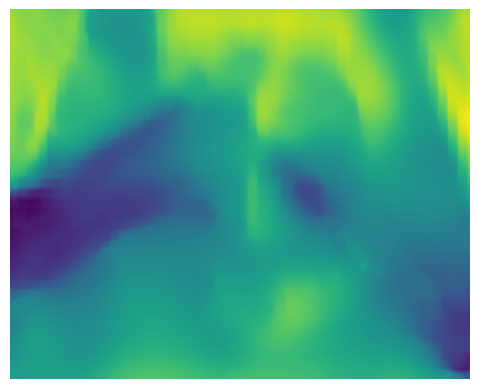

In [ ]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DepthAnythingForDepthEstimation
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn

class DepthAnythingDepthEstimationHead(nn.Module):

    def __init__(self, model_head):
        super().__init__()

        # self.head_in_index = config.head_in_index
        # self.patch_size = config.patch_size

        # features = config.fusion_hidden_size
        self.conv1 = model_head.conv1
        self.conv2 = model_head.conv2
        self.activation1 = nn.ReLU()
        self.conv3 = model_head.conv3
        self.activation2 = nn.ReLU()

    def forward(self, hidden_states, height, width):
        #hidden_states = hidden_states[self.head_in_index]#[1, 64, 144, 176]
        #print('Final Head:',hidden_states.shape)
        predicted_depth = self.conv1(hidden_states)
        predicted_depth = nn.functional.interpolate(
            predicted_depth,
            (int(height), int(width)),
            mode="bilinear",
            align_corners=True,
        )
        print('head predicted_depth:', predicted_depth.shape)
        predicted_depth = self.conv2(predicted_depth)
        predicted_depth = self.activation1(predicted_depth)
        predicted_depth = self.conv3(predicted_depth)
        predicted_depth = self.activation2(predicted_depth)
        predicted_depth = predicted_depth.squeeze(dim=1)  # shape (batch_size, height, width)

        return predicted_depth

#Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))

class Customised_DAM(nn.Module):
    def __init__(self,):
        super(Customised_DAM, self).__init__()
        model = DepthAnythingForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")
        self.config = model.config
        old_weight = model.backbone.embeddings.patch_embeddings.projection.weight
        old_bias = model.backbone.embeddings.patch_embeddings.projection.bias
        model.backbone.embeddings.patch_embeddings.projection = nn.Conv2d(in_channels=6, out_channels=384, kernel_size=(14, 14), stride=(14, 14))
        # print('model.backbone.embeddings.patch_embeddings.projection.weight[:,:3,:,:]', model.backbone.embeddings.patch_embeddings.projection.weight[:,:3,:,:].shape)
        # print('model.backbone.embeddings.patch_embeddings.projection.weight[:,3:6,:,:]', model.backbone.embeddings.patch_embeddings.projection.weight.shape)
        with torch.no_grad():
            model.backbone.embeddings.patch_embeddings.projection.weight[:,:3,:,:] = old_weight
            model.backbone.embeddings.patch_embeddings.projection.weight[:,3:6,:,:] = old_weight
            model.backbone.embeddings.patch_embeddings.projection.bias = old_bias
        # model.backbone.config.num_channels=6
        # model.backbone.embeddings.config.num_channels=6
        model.backbone.embeddings.patch_embeddings.num_channels=6
        # self.embeddings = model.backbone.embeddings
        # self.encoder = model.backbone.encoder
        self.backbone = model.backbone
        # print('self.backbone:', self.backbone)
        self.neck = model.neck
        model_head = model.head
        self.head = DepthAnythingDepthEstimationHead(model_head)
        model.post_init()


    def forward(self, pixel_values):
        # print('pixel_values:', pixel_values.shape)
        # print('self.backbone', self.backbone)

        outputs = self.backbone(
            pixel_values, output_hidden_states=None, output_attentions=None
        ) # pixel_values:[3, 256, 320] , output:4, [1, 397, 384]
        hidden_states = outputs.feature_maps
        _, _, height, width = pixel_values.shape
        patch_size = self.config.patch_size
        patch_height = height // patch_size
        patch_width = width // patch_size
        # print('h,w, p, ph, pw', height, width, patch_size, patch_height, patch_width) #h,w, p, ph, pw 256 320 14 18 22
        # print('hidden_states1', len(hidden_states), hidden_states[0].shape, hidden_states[1].shape, hidden_states[2].shape, hidden_states[3].shape)
        hidden_states = self.neck(hidden_states, patch_height, patch_width)
        #[1, 64, 18, 22], [1, 64, 36, 44], [1, 64, 72, 88], [1, 64, 144, 176]
        # print('hidden_states2', len(hidden_states), hidden_states[0].shape, hidden_states[1].shape, hidden_states[2].shape, hidden_states[3].shape)
        predicted_depth = self.head(hidden_states[3], height, width)
        # outputs = {}
        # outputs[("disp", 0)] = self.head(hidden_states[3], height, width)
        # outputs[("disp", 1)] = self.head(hidden_states[3], height/2, width/2)
        # outputs[("disp", 2)] = self.head(hidden_states[3], height/4, width/4)
        # outputs[("disp", 3)] = self.head(hidden_states[3], height/8, width/8)
        # print(outputs[("disp", 0)].shape, outputs[("disp", 1)].shape,outputs[("disp", 2)].shape,outputs[("disp", 3)].shape,)
        # return outputs[("disp", 0)]
        return predicted_depth

url = "https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs13304-020-00913-4/MediaObjects/13304_2020_913_Fig2_HTML.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
print('raw input', image.size[::-1])
inputs = image_processor(images=image, return_tensors="pt")

# image_shape=(256,320)
# inputs['pixel_values'] = torch.nn.functional.interpolate(inputs['pixel_values'], size=image_shape, mode="bilinear", align_corners=True)
inputs['pixel_values'] = torch.cat([inputs['pixel_values'], inputs['pixel_values']], dim=1)
model_dare = Customised_DAM()
with torch.no_grad():
    predicted_depth = model_dare(**inputs)

print('raw input', image.size[::-1],'inputs',inputs['pixel_values'].shape, 'predicted_depth', predicted_depth.shape)

# visualize the prediction
output = predicted_depth.squeeze().cpu().numpy()

print('Original model train on the scale of 0 to 30')
print('prediction: min scale =', output.min(), 'max scale=', output.max())

#Rescale the reconstruction according to your application
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)
plt.figure(122),plt.axis('OFF'),plt.imshow(depth);

In [ ]:
inputs['pixel_values'].shape

torch.Size([1, 3, 518, 644])

In [ ]:
imgs = torch.cat([inputs['pixel_values'], inputs['pixel_values']], dim=1)
imgs.shape

torch.Size([1, 6, 518, 644])

In [ ]:
/usr/local/lib/python3.10/dist-packages/transformers/models/depth_anything/modeling_depth_anything.py